# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [87]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [88]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo

company1 = "bankofmontreal"
company2 ="wellsfargo"
company3 = "jpmorganchase"

DATA_FILES_PATH="gs://report_insights"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ
OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro"
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [64]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [65]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [66]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [67]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [68]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [69]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/*']
);
"""

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 147 files in storage
Sample files:


                                                 uri      size
0  gs://report_insights/amgen/amgen_annualreport_...  12663856
1  gs://report_insights/amgen/amgen_annualreport_...   3651904
2  gs://report_insights/amgen/amgen_annualreport_...   3777808
3  gs://report_insights/amgen/amgen_annualreport_...  12725236
4  gs://report_insights/amgen/amgen_annualreport_...   8154936

[5 rows x 2 columns]


#  ֎ Extract Financial & ESG Data - Using ML.GENERATE_TEXT

In [71]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Read the filename. If it is a sustainability report, please get only ESG details. If it is an annual report, get just the financials as below.
        Ensure you fetch details so it has answers for:
        Financial Performance
        What is the total revenue this year?
        How has revenue changed compared to last year?
        What is the net profit or loss?
        How have the earnings per share (EPS) changed?
        Are gross margins improving or declining?
        Are operating margins stable or volatile?
        How has net margin shifted year over year?
        Is cash flow from operations positive and consistent?
        How much free cash flow is available?
        How are working capital levels trending?
        Balance Sheet & Liquidity
        What is the total debt level?
        Is the debt-to-equity ratio rising or falling?
        Does the company have enough liquidity to cover short-term liabilities?
        What is the current ratio and quick ratio?
        How much cash and equivalents are available?
        Are interest expenses sustainable?
        How sensitive is the company to interest rate changes?
        What is the level of contingent liabilities?
        Business Strategy
        What are the company’s core growth initiatives?
        Is management investing in new markets or products?
        How much is spent on research and development (R&D)?
        Are acquisitions or divestitures planned?
        Is the company expanding geographically?
        What is the company’s competitive advantage?
        Is the advantage sustainable against competitors?
        Is digital transformation a core part of the strategy?
        Risk Factors
        What macroeconomic risks affect the business?
        What industry-specific risks are highlighted?
        What operational risks are disclosed?
        Are supply chain risks material?
        Are legal or regulatory risks mentioned?
        How is foreign exchange risk managed?
        How dependent is revenue on a few customers?
        Are raw material price risks significant?
        Governance & Leadership
        Is the board majority independent?
        How many women or minorities are on the board?
        Is executive compensation performance-linked?
        Does management own significant equity?
        Are shareholder rights well protected?
        Is succession planning disclosed?
        Has management delivered on past promises?
        Is the auditor independent and credible?
        Shareholder Value
        Is the company paying dividends?
        Is the dividend payout sustainable?
        Is the dividend policy clear?
        Are share buybacks taking place?
        Is return on equity (ROE) improving?
        Is return on assets (ROA) stable?
        Has shareholder equity grown consistently?
        What is the earnings guidance for next year?
        Investor Questions – Sustainability Reports
        Environmental
        What is the total Scope 1 emissions?
        What is the total Scope 2 emissions?
        What is the total Scope 3 emissions?
        Are science-based targets disclosed?
        Has the company committed to net-zero?
        What percentage of energy is renewable?
        Is energy efficiency improving year over year?
        What is the total water withdrawal?
        What is water recycled or reused?
        Is the company exposed to water stress?
        How much total waste is generated?
        How much waste is recycled or diverted from landfill?
        Are hazardous waste levels disclosed?
        How sustainable are raw material sourcing practices?
        Are biodiversity risks addressed?
        Social
        What is the total workforce size?
        What percentage of employees are women?
        What percentage of leadership roles are held by women?
        What is minority representation in the workforce?
        What is the employee turnover rate?
        How many workplace injuries occurred?
        What is the lost-time injury frequency rate?
        Are labor rights respected across the supply chain?
        Is child labor risk disclosed in supply chains?
        Are employee training hours increasing per year?
        Are wages above local living wage levels?
        Is there employee engagement survey data?
        What community development initiatives exist?
        What philanthropic contributions were made?
        Is there disclosure on data privacy and cybersecurity?
        Governance (ESG-specific)
        Is there a dedicated board ESG committee?
        How often does the board review ESG matters?
        Is ESG risk included in enterprise risk management?
        Is executive compensation tied to ESG goals?
        Are ESG targets linked to management incentives?
        Is ESG performance externally assured?
        Are ESG disclosures aligned with GRI or SASB?
        Does the company report under TCFD or ISSB?
        Is CDP reporting publicly available?
        Are stakeholder engagement practices disclosed?
        Risk & Opportunity
        What are the identified physical climate risks?
        What are the identified transition risks?
        Is there disclosure on carbon pricing exposure?
        How dependent is revenue on carbon-intensive activities?
        What sustainability-linked opportunities are identified?
        Are green products or services generating revenue?
        Is access to sustainable finance increasing?
        Are suppliers evaluated for ESG performance?
        Are ESG clauses included in supplier contracts?
        Is there disclosure on product lifecycle impacts?
      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 32 files!


# ֎Extract Financial & ESG Data - using AI.GENERATE
### *Alternate Method to ML.GENERATE_TEXT:*


In [72]:

print(f"🧠 Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql2 = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED2_TABLE_ID}` AS
SELECT
  uri,
  AI.GENERATE(
    CONCAT(
 "You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.\n",
"Fetch Financial and Sustainability Details including tabular and image data for each PDF.\n",
"Ensure you fetch details so it has answers for the below: fetch as-it-is. Donot format",
"Read the filename. If its a sustainability report, please get only ESG details. And if its an annual report, get just the financials as below:",
"Financial Performance\n",
"What is the total revenue this year?\n",
"How has revenue changed compared to last year?\n",
"What is the net profit or loss?\n",
"How have the earnings per share (EPS) changed?\n",
"Are gross margins improving or declining?\n",
"Are operating margins stable or volatile?\n",
"How has net margin shifted year over year?\n",
"Is cash flow from operations positive and consistent?\n",
"How much free cash flow is available?\n",
"How are working capital levels trending?\n\n",

"Balance Sheet & Liquidity\n",
"What is the total debt level?\n",
"Is the debt-to-equity ratio rising or falling?\n",
"Does the company have enough liquidity to cover short-term liabilities?\n",
"What is the current ratio and quick ratio?\n",
"How much cash and equivalents are available?\n",
"Are interest expenses sustainable?\n",
"How sensitive is the company to interest rate changes?\n",
"What is the level of contingent liabilities?\n\n",

"Business Strategy\n",
"What are the company’s core growth initiatives?\n",
"Is management investing in new markets or products?\n",
"How much is spent on research and development (R&D)?\n",
"Are acquisitions or divestitures planned?\n",
"Is the company expanding geographically?\n",
"What is the company’s competitive advantage?\n",
"Is the advantage sustainable against competitors?\n",
"Is digital transformation a core part of the strategy?\n\n",

"Risk Factors\n",
"What macroeconomic risks affect the business?\n",
"What industry-specific risks are highlighted?\n",
"What operational risks are disclosed?\n",
"Are supply chain risks material?\n",
"Are legal or regulatory risks mentioned?\n",
"How is foreign exchange risk managed?\n",
"How dependent is revenue on a few customers?\n",
"Are raw material price risks significant?\n\n",

"Governance & Leadership\n",
"Is the board majority independent?\n",
"How many women or minorities are on the board?\n",
"Is executive compensation performance-linked?\n",
"Does management own significant equity?\n",
"Are shareholder rights well protected?\n",
"Is succession planning disclosed?\n",
"Has management delivered on past promises?\n",
"Is the auditor independent and credible?\n\n",

"Shareholder Value\n",
"Is the company paying dividends?\n",
"Is the dividend payout sustainable?\n",
"Is the dividend policy clear?\n",
"Are share buybacks taking place?\n",
"Is return on equity (ROE) improving?\n",
"Is return on assets (ROA) stable?\n",
"Has shareholder equity grown consistently?\n",
"What is the earnings guidance for next year?\n\n",

"Investor Questions – Sustainability Reports\n\n",

"Environmental\n",
"What is the total Scope 1 emissions?\n",
"What is the total Scope 2 emissions?\n",
"What is the total Scope 3 emissions?\n",
"Are science-based targets disclosed?\n",
"Has the company committed to net-zero?\n",
"What percentage of energy is renewable?\n",
"Is energy efficiency improving year over year?\n",
"What is the total water withdrawal?\n",
"What is water recycled or reused?\n",
"Is the company exposed to water stress?\n",
"How much total waste is generated?\n",
"How much waste is recycled or diverted from landfill?\n",
"Are hazardous waste levels disclosed?\n",
"How sustainable are raw material sourcing practices?\n",
"Are biodiversity risks addressed?\n\n",

"Social\n",
"What is the total workforce size?\n",
"What percentage of employees are women?\n",
"What percentage of leadership roles are held by women?\n",
"What is minority representation in the workforce?\n",
"What is the employee turnover rate?\n",
"How many workplace injuries occurred?\n",
"What is the lost-time injury frequency rate?\n",
"Are labor rights respected across the supply chain?\n",
"Is child labor risk disclosed in supply chains?\n",
"Are employee training hours increasing per year?\n",
"Are wages above local living wage levels?\n",
"Is there employee engagement survey data?\n",
"What community development initiatives exist?\n",
"What philanthropic contributions were made?\n",
"Is there disclosure on data privacy and cybersecurity?\n\n",

"Governance (ESG-specific)\n",
"Is there a dedicated board ESG committee?\n",
"How often does the board review ESG matters?\n",
"Is ESG risk included in enterprise risk management?\n",
"Is executive compensation tied to ESG goals?\n",
"Are ESG targets linked to management incentives?\n",
"Is ESG performance externally assured?\n",
"Are ESG disclosures aligned with GRI or SASB?\n",
"Does the company report under TCFD or ISSB?\n",
"Is CDP reporting publicly available?\n",
"Are stakeholder engagement practices disclosed?\n\n",

"Risk & Opportunity\n",
"What are the identified physical climate risks?\n",
"What are the identified transition risks?\n",
"Is there disclosure on carbon pricing exposure?\n",
"How dependent is revenue on carbon-intensive activities?\n",
"What sustainability-linked opportunities are identified?\n",
"Are green products or services generating revenue?\n",
"Is access to sustainable finance increasing?\n",
"Are suppliers evaluated for ESG performance?\n",
"Are ESG clauses included in supplier contracts?\n",
"Is there disclosure on product lifecycle impacts?\n"
      "Open and Read the PDF: "
    ),
    connection_id => '{QUALIFIED_CLOUD_RES_CONN}',
    endpoint => '{MODEL_ENDPOINT}',
    output_schema => 'uri STRING, response_text STRING'
  ).response_text AS response_text
FROM `{QUALIFIED_RAW_TABLE_ID}`
WHERE uri LIKE '%{company1}%' OR uri LIKE '%{company2}%' OR uri LIKE '%{company3}%';
"""

      # JSON_VALUE(
      #   OBJ.GET_ACCESS_URL(
      #     OBJ.MAKE_REF(uri, '{QUALIFIED_CLOUD_RES_CONN}'),
      #     'r'
      #   ),
      #   '$.access_urls.read_url'
      # )

# try:
#     print("⏳ Processing... This may take 2-3 minutes")
#     job = client.query(generate_text_sql2)
#     job.result()

#     # Check results
#     check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_CURATED2_TABLE_ID}`"
#     result = client.query(check_sql).result()
#     count = list(result)[0][0]
#     print(f"✅ Successfully processed {count} files!")

# except Exception as e:
#     print(f"⚠️  Processing issue: {e}")


🧠 Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...


# 🧹 Extract Clean Text Response

In [73]:

print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2019.pdf
Text: Based on the JPMorgan Chase & Co. Environmental, Social & Governance Report for 2019, here are the key financial and sustainability details.

**Note:** This is an Environmental, Social, and Governance...

File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2024.pdf
Text: Here are the ESG and financial details from the JPMorgan Chase & Co. 2024 Climate Report.

### **ESG Details**

**Environmental**

| Metric | Value | Source |
| --- | --- | --- |
| **Total Scope 1 Emi...

File: gs://report_insights/jpmorganchase/jpmorganchase_sustainabilityreport_2020.pdf
Text: Based on the JPMorgan Chase & Co. 2020 Environmental, Social & Governance Report, here are the key ESG details:

### **Environmental**

**Emissions & Targets**
*   **Total Scope 1 emissions:** 69,570 ...



# 📊 Extract Structured Metrics - Using AI.GENERATE_TABLE

In [74]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate Metric Table
---



In [75]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# Output 1
### Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [76]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "bankofmontreal"
year = 2021
rtype = "Annual"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")
    # --- Grab the first row (or loop if multiple) ---
    text = df["extracted_text"].iloc[0]

    # --- Pretty display in Colab ---
    print("\n\n===========================================================================\n\n")
    display(Markdown(text))

Here is a detailed analysis of BMO Financial Group's 2021 Annual Report, with a focus on financial and sustainability-related information.

### **Financial Performance**

| Metric | 2021 | 2020 | Change | Analysis |
| :--- | :--- | :--- | :--- | :--- |
| **Total Revenue** | $27,186 million | $25,186 million | ▲ 7.9% | Revenue saw strong growth, driven by increases in both net interest income and non-interest revenue (p. 26, 33). |
| **Net Income** | $7,754 million | $5,097 million | ▲ 52.1% | Net income increased significantly, reflecting a recovery from the pandemic's impact, lower provisions for credit losses, and strong revenue growth (p. 33). |
| **Diluted EPS** | $11.58 | $7.55 | ▲ 53.4% | The substantial increase in net income translated directly to a strong recovery in earnings per share (p. 26). |
| **Efficiency Ratio (Gross, Reported)** | 57.0% | 56.3% | ▼ 0.7 p.p. | The reported efficiency ratio (a measure of productivity where lower is better) slightly worsened. However, the adjusted efficiency ratio improved from 55.8% to 53.6%, indicating better underlying cost management (p. 25, 38). |
| **Net Margin** | 28.5% | 20.2% | ▲ 8.3 p.p. | The net profit margin saw a substantial improvement, driven by the strong recovery in net income relative to revenue growth (Calculated from p. 26). |
| **Cash Flow from Operations** | $44,049 million | $50,836 million | ▼ 13.3% | Cash flow from operations remained strongly positive and substantial, though it decreased from the prior year's exceptionally high level (p. 152). |
| **Free Cash Flow** | Not explicitly stated. | Not explicitly stated. | - | This metric is not standard for financial institutions. Net cash from operating activities is the key indicator. |
| **Working Capital** | Not applicable. | Not applicable. | - | This metric is not standard for financial institutions. |

### **Balance Sheet & Liquidity**

| Metric | 2021 | 2020 | Analysis |
| :--- | :--- | :--- | :--- |
| **Total Debt (Subordinated)** | $6,893 million | $8,416 million | The level of subordinated debt, a component of regulatory capital, decreased from the prior year due to redemptions net of a new issuance (p. 150, 187). |
| **Debt-to-Equity Ratio** | 16.18 | 15.77 | The ratio of total liabilities to total equity increased slightly, indicating a modest rise in leverage (Calculated from p. 150). |
| **Liquidity** | LCR: 125% | LCR: 131% | The average Liquidity Coverage Ratio (LCR) of 125% for Q4 2021 is well above the 100% regulatory minimum, indicating a strong liquidity position to cover short-term obligations (p. 104). |
| **Current/Quick Ratio** | Not applicable. | Not applicable. | These ratios are not standard metrics for financial institutions. LCR and NSFR are the relevant measures. |
| **Cash and Equivalents** | $93,261 million | $57,408 million | Cash and cash equivalents increased significantly, reflecting higher customer deposits and a change in the mix of liquid assets (p. 65, 150). |
| **Interest Rate Sensitivity** | - | - | The company is sensitive to interest rate changes. A 100-basis-point increase in rates would have a mixed but managed impact on earnings and economic value across its structural and insurance portfolios (p. 97, 98). |
| **Contingent Liabilities** | $228,005 million | $221,609 million | The maximum amount payable for commitments, guarantees, and letters of credit increased slightly. These represent potential future obligations (p. 206). |

### **Business Strategy**

*   **Core Growth Initiatives:** BMO's strategy is anchored in its purpose, "Boldly Grow the Good," focusing on three core commitments:
    1.  **A Thriving Economy:** Supporting small businesses, women entrepreneurs, and Indigenous and military customers (p. 10, 17).
    2.  **A Sustainable Future:** Acting as a lead partner for clients in the transition to a net-zero world (p. 10, 12).
    3.  **An Inclusive Society:** Committing to "Zero Barriers to Inclusion 2025" to support underrepresented groups (p. 10, 17).
*   **New Markets & Products:** The company is expanding its U.S. commercial banking presence nationally, opening new offices in cities like Atlanta, Denver, and Orlando. It has also launched new products like the BMO eclipse Visa cards and the BMO Family Bundle to attract new customers (p. 9, 42).
*   **R&D Spending:** Not explicitly disclosed. Investment is framed in terms of technology and innovation.
*   **Acquisitions & Divestitures:** The report mentions the significant acceleration of its U.S. presence since the 1984 acquisition of Harris Bank (p. 9). In 2021, BMO completed the sale of its Private Banking business in Asia and its EMEA asset management business (p. 183).
*   **Geographic Expansion:** BMO is focused on growing as a leading North American bank. In 2021, 36% of revenue came from its U.S. businesses, which represent the fastest-growing geographic segment. The U.S. footprint is now described as national, extending beyond its traditional Midwest base (p. 3, 8, 9).
*   **Competitive Advantage:** BMO's advantage is built on being a purpose-driven, diversified North American bank with a 204-year history. It is the only bank that runs all its operating groups on an integrated basis across the U.S. and Canadian border, driving efficiency and scale (p. 2, 8).
*   **Digital Transformation:** "Digital First" is a core strategic priority, built for speed, efficiency, and scale. The bank views digital as the way it operates every part of the business, not just as a channel. This includes harnessing data, AI, and cloud banking to personalize experiences and automate processes (p. 10, 14, 15).

### **Risk Factors**

*   **Macroeconomic Risks:** The business is affected by general economic conditions, the ongoing uncertainty of the COVID-19 pandemic, supply-chain disruptions, and inflation. Escalating housing prices in Canada and the U.S. are also noted as a risk (p. 31, 76, 78).
*   **Industry-Specific Risks:** The global reform of benchmark interest rates (IBOR transition) presents complex financial, operational, and legal risks (p. 76).
*   **Operational Risks:** Cyber Security is highlighted as a top risk, with the bank investing in its Financial Crimes Unit and technology to counter threats like data loss and ransomware. Technology resiliency and third-party risk are also key concerns (p. 76, 109).
*   **Supply Chain Risks:** Global supply-chain disruptions are mentioned as a headwind tempering economic growth and contributing to inflation (p. 9, 31).
*   **Legal & Regulatory Risks:** The company is subject to extensive regulation and evolving supervisory expectations, including consumer protection, privacy (CCPA, GDPR), and climate-related disclosure rules. The report also discloses a material legal proceeding related to the Petters Ponzi scheme (p. 78, 111, 208).
*   **Foreign Exchange Risk:** The company manages structural foreign exchange risk arising from its net investment in U.S. operations. It may use forward contracts to hedge its U.S. dollar earnings and capital ratios (p. 98).

### **Governance & Leadership**

*   **Board Independence:** The 13-member board is majority independent, with most members being corporate directors or executives from other companies. The CEO is the only internal executive on the board (p. 18).
*   **Board Diversity:** The board is gender-balanced, comprising six women and seven men. It also has balanced representation from Canada (seven directors) and the United States (six directors) (p. 7).
*   **Executive Compensation:** Compensation is linked to performance. In 2021, higher performance-based compensation was a key driver of increased non-interest expense, reflecting improved business results (p. 38).
*   **Management Equity:** Specific equity ownership by management is not detailed, but the report notes that 84.7% of Canadian employees participate in the BMO Employee Share Ownership Plan (p. 215).
*   **Shareholder Rights:** The company has a 193-year record of paying dividends. It has a clear dividend policy and plans for a Normal Course Issuer Bid (share buyback), demonstrating a commitment to returning capital to shareholders (p. 5, 74).
*   **Succession Planning:** The report mentions that the Risk Review Committee of the board evaluates the Chief Risk Officer, including input into succession planning for the role (p. 82).
*   **Auditor Independence:** The auditor is KPMG LLP. The Audit and Conduct Review Committee has a robust process for overseeing auditor performance and independence, including a comprehensive review every five years and ensuring lead partner rotation (p. 122).

### **Shareholder Value**

| Metric | 2021 | 2020 | Analysis |
| :--- | :--- | :--- | :--- |
| **Dividends Paid** | Yes | Yes | BMO has the longest-running dividend payout record of any company in Canada, at 193 years. The dividend declared per share was $4.24 in 2021 (p. 5, 26). |
| **Dividend Payout Ratio** | 36.5% | 56.1% | The payout ratio is within the company's target range of 40-50% (on a rolling basis), indicating the dividend is sustainable (p. 26, 74). |
| **Share Buybacks** | Yes (Planned) | No | The company announced its intention to establish a new Normal Course Issuer Bid (NCIB) to repurchase up to 22.5 million common shares (p. 72). |
| **Return on Equity (ROE)** | 14.9% | 10.1% | Reported ROE improved significantly, exceeding the 2020 level and approaching the medium-term objective of 15% or more (p. 26). |
| **Return on Assets (ROA)** | 0.79% | 0.54% | ROA showed a strong recovery from the prior year, reflecting higher profitability (p. 124). |
| **Shareholder Equity Growth** | Yes | Yes | Total equity grew to $57,523 million from $56,593 million in the prior year, driven by retained earnings (p. 66, 150). |
| **Earnings Guidance** | Not provided. | Not provided. | The report provides an economic outlook for 2022, expecting robust growth, but does not give specific earnings guidance (p. 31). |

### **Sustainability (ESG) Highlights**

*   **Net-Zero Commitment:** BMO has a clear ambition to be its clients' lead partner in the transition to a net-zero world, targeting net-zero financed emissions in its lending portfolio by 2050 (p. 12).
*   **Sustainable Finance:** The bank is on track to meet its 2025 goal of mobilizing $300 billion in capital for clients pursuing sustainable outcomes. It also launched a $250 million Impact Investment Fund (p. 17).
*   **Renewable Energy:** Since 2020, BMO has committed to matching 100% of its global electricity usage with purchases of renewable electricity (p. 13).
*   **Diversity & Inclusion:**
    *   **Board:** 6 women and 7 men (p. 7).
    *   **Senior Leadership:** For the last six years, more than 40% of senior leaders have been women (p. 17).
    *   **U.S. Target:** A target is set to increase the representation of People of Color in U.S. senior roles to 30%; the bank is over two-thirds of the way there (p. 5).
*   **Community Investment:**
    *   **BMO EMpower:** A US$5 billion, five-year commitment to address systemic barriers faced by minority businesses, communities, and families in the U.S. (p. 5).
    *   **Affordable Housing:** Earmarked $12 billion to finance affordable housing across Canada over 10 years (p. 5).
    *   **Indigenous Reconciliation:** Committed $600,000 in 2021 to advance Truth and Reconciliation in Canada (p. 17).
*   **ESG Governance & Reporting:** The bank has a dedicated Chief Sustainability Officer and Sustainability Council. It reports in line with GRI, SASB, and TCFD frameworks and has been recognized as one of the World's Most Ethical Companies and a leader on the Dow Jones Sustainability Index (p. 5, 113, 115).

Based on the JPMorgan Chase & Co. Environmental, Social & Governance Report for 2019, here are the key financial and sustainability details.

**Note:** This is an Environmental, Social, and Governance (ESG) Report. As stated on page 4, "For information about the firm's financial performance, please refer to the firm's quarterly earnings materials as well as quarterly and annual reports on Form 10-Q and Form 10-K, respectively." Therefore, detailed financial performance and balance sheet metrics like revenue, net profit, EPS, margins, and debt levels are not included in this document. The analysis below focuses on the ESG and strategic information available within this report.

### **Financial & Strategic Overview**

**Financial Snapshot (High-Level)**
*   **Total Assets:** $2.7 trillion as of December 31, 2019 (Page 4).

**Business Strategy**
*   **Core Growth Initiatives:** The firm's strategy is focused on advancing inclusive growth and sustainability. Key focus areas include:
    *   **Preparing Workers for the Future of Work:** A $350 million, five-year investment to equip people with skills for a changing economy (Page 25).
    *   **Supporting Small Businesses:** Providing capital and resources to underserved and minority entrepreneurs through programs like the Entrepreneurs of Color Fund (Page 25).
    *   **Cultivating Thriving Neighborhoods:** Investing in affordable housing and community development (Page 25).
    *   **Advancing Sustainability:** A commitment to facilitate $200 billion in financing in 2020 to support climate action and the UN Sustainable Development Goals (SDGs) (Page 28).
*   **New Markets and Products:**
    *   The firm entered 16 new U.S. markets and is expanding its branch presence, with 30% of new branches planned for low- and moderate-income communities (Pages 13, 16).
    *   New products launched to improve customers' financial health include Chase Secure Banking℠, Autosave, and the Credit Journey℠ tool (Page 13).
*   **Competitive Advantage:** The firm's advantage is built on its scale, global presence, expertise, and a stated commitment to its Business Principles, which emphasize exceptional client service, operational excellence, integrity, and a strong team culture (Page 35).
*   **Digital Transformation:** Digital is a core part of the strategy, serving 52 million active digital users. The firm is investing in digital fluency for its employees and using technology like machine learning to detect fraud (Pages 13, 16, 20).

**Risk Factors**
*   **Macroeconomic Risks:** The report acknowledges the "human and economic impacts of the COVID-19 pandemic" and identifies "climate change" as a pressing global challenge with profound potential consequences (Page 2).
*   **Operational & Industry-Specific Risks:**
    *   **Cybersecurity:** Identified as "one of the biggest threats facing the global financial system" and a top priority for the firm (Page 11).
    *   **Conduct Risk:** The risk of employee actions leading to unfair customer outcomes or reputational damage is actively managed through a dedicated framework (Page 11).
    *   **Financial Crimes:** The firm dedicates significant resources to combatting money laundering and terrorist financing through a global compliance program (Page 11).

### **Governance & Leadership**

*   **Board Independence:** The Board of Directors is majority independent. "Apart from our CEO, all of our Directors are independent... We have a Lead Independent Director who is appointed annually by the independent Directors" (Page 8).
*   **Board Diversity:**
    *   As of the 2019 annual meeting, the 11-member board included two women and two Black directors (Page 8).
    *   For the 2020 annual meeting, of the 10 nominated individuals, three are women and one is Black (Page 8).
*   **Executive Compensation:**
    *   **Performance-Linked:** Compensation for senior executives is determined using a "balanced and discretionary approach" that assesses performance against four dimensions: Business Results; Risk, Controls & Conduct; Client/Customer/Stakeholder engagement; and Teamwork & Leadership (Page 9).
    *   **ESG Linkage:** The compensation framework includes non-financial factors such as "engagement in communities" and creating a "diverse, inclusive and respectful environment," indirectly linking pay to social and governance performance (Page 9).
*   **Shareholder Engagement:** The firm conducts a formal shareholder outreach program, engaging with holders of over 50% of outstanding common stock in 2019 on topics including executive compensation, corporate governance, and climate change strategy (Page 6).

### **Environmental Performance**

*   **Greenhouse Gas (GHG) Emissions (2019, MtCO₂e):**
    *   **Scope 1:** 81,655
    *   **Scope 2 (Market-based):** 556,142
    *   **Scope 3 (Employee Travel):** 181,004
    *   **Total Scope 1 & 2 (Market-based):** 637,798, a 54% reduction from the 2005 baseline.
    *(Source: Environmental Data Table, Page 34)*
*   **Net-Zero Commitment:** The report does not state a formal net-zero commitment for the 2019 reporting year.
*   **Renewable Energy:**
    *   **2019 Performance:** 22% of global power use was from renewable sources (Page 34).
    *   **2020 Goal:** The company committed to sourcing renewable energy for 100% of its global power needs by the end of 2020 (Page 28).
*   **Energy & Water:**
    *   **Total Energy Consumption (2019):** 2,082,277 MWh, a 34% reduction from the 2005 baseline (Page 34).
    *   **Total Water Withdrawal (2019, U.S. only):** 5,091,865 m³ (Page 34).
*   **Biodiversity:** The firm supports biodiversity by purchasing carbon offsets from forest management projects, such as the Hawk Mountain Sanctuary, which protects 2,500 acres of habitat for birds of prey (Page 33).

### **Social Performance**

*   **Workforce Demographics (2019):**
    *   **Total Workforce:** 256,981 employees (Page 34).
    *   **Women in Workforce:** 51% globally.
    *   **Women in Leadership:** 50% of the Operating Committee and 25% of the Management Team were women.
    *   **Minority Representation (U.S. only):** 49% of the U.S. workforce were ethnic minorities. 8% of the Operating Committee and 19% of the Management Team were ethnic minorities.
    *(Source: Key 2019 Statistics, Page 18)*
*   **Employee Training & Development:**
    *   The firm delivered nearly 10 million hours of training to employees in 2019 (Page 19).
    *   It invested approximately $200 million annually in employee training programs (Page 19).
*   **Wages:** The firm increased wages for U.S. employees at the lower end of the pay scale to a range between $15 and $18 per hour (Page 22).
*   **Community Investment:**
    *   **AdvancingCities:** A $500 million, five-year initiative to expand economic opportunity in cities. In 2019, this included awards totaling $15 million to five U.S. cities (Page 27).
    *   **Philanthropic Giving:** The firm made an initial $200 million commitment to assist those affected by COVID-19 (Page 24).
*   **Data Privacy & Cybersecurity:** Protecting customer data is a stated priority, with robust internal policies, security measures, and a dedicated cybersecurity team that operates 24/7. The firm also collaborates with industry groups to enhance systemic resilience (Pages 11, 12, 15).

### **ESG Governance, Risk & Opportunity**

*   **Board ESG Oversight:** The **Public Responsibility Committee** of the Board provides oversight on sustainability, community investment, and other public responsibility matters (Page 9). The **Compensation & Management Development Committee (CMDC)** oversees firm culture and conduct-related matters (Page 8).
*   **ESG Risk Management:** Environmental and social matters are integrated into the firm's risk management process. A dedicated environmental and social risk management group reviewed approximately 2,100 transactions in 2019. The firm also integrated climate-related risks into its firmwide risk identification and assessment processes (Page 31).
*   **Sustainability-Linked Opportunities:**
    *   **Sustainable Finance Target:** The firm set a goal to facilitate **$200 billion** in 2020 for financing that supports climate action and the UN SDGs (Page 28).
    *   **Green Bonds:** Underwrote $14.6 billion in green and sustainable bonds in 2019 (Page 29).
    *   **Renewable Energy Finance:** Since 2003, the firm has committed or arranged over $24 billion in tax equity financing for U.S. wind, solar, and geothermal projects (Page 29).
*   **ESG Reporting & Assurance:**
    *   **Frameworks:** The report is informed by the Global Reporting Initiative (GRI), Sustainability Accounting Standards Board (SASB), and the Task Force on Climate-Related Financial Disclosures (TCFD) (Page 3).
    *   **External Assurance:** 2019 data for Scope 1, 2, and 3 GHG emissions and U.S. water consumption were externally verified (Page 34, footnote 'b').

#Output 2:
### Plots for revenue and net income

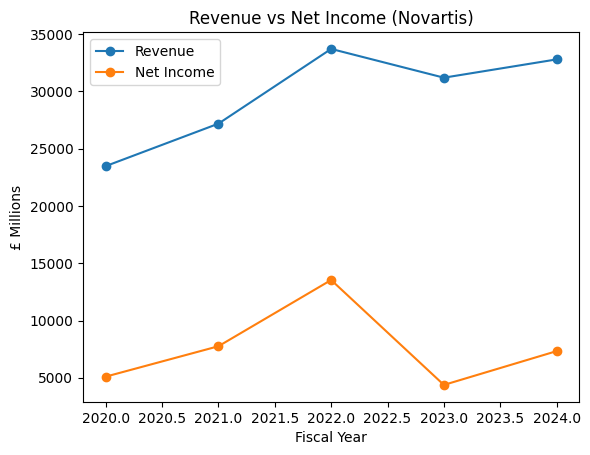

In [77]:
df_company = df[
    (df["company_name"].str.lower() == "bankofmontreal") &
    (df["report_type"].str.lower() == "annual")
]
df_company = df_company.sort_values("fiscal_year")

plt.plot(df_company["fiscal_year"], df_company["revenue_millions"], marker="o", label="Revenue")
plt.plot(df_company["fiscal_year"], df_company["net_income_millions"], marker="o", label="Net Income")
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue vs Net Income (Novartis)")
plt.legend()
plt.show()

# Output 3:
### Revenue and Income for multiple companies and comparisons

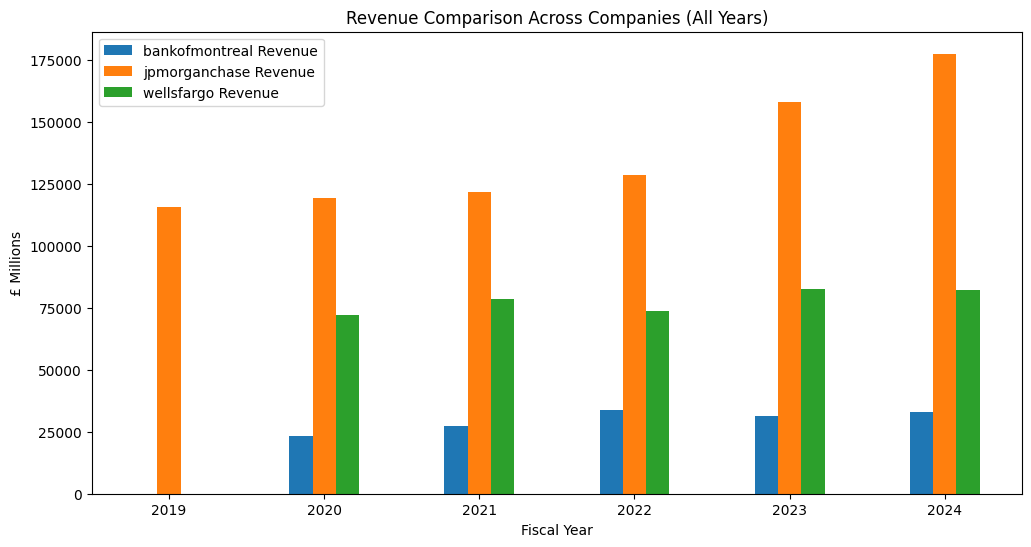

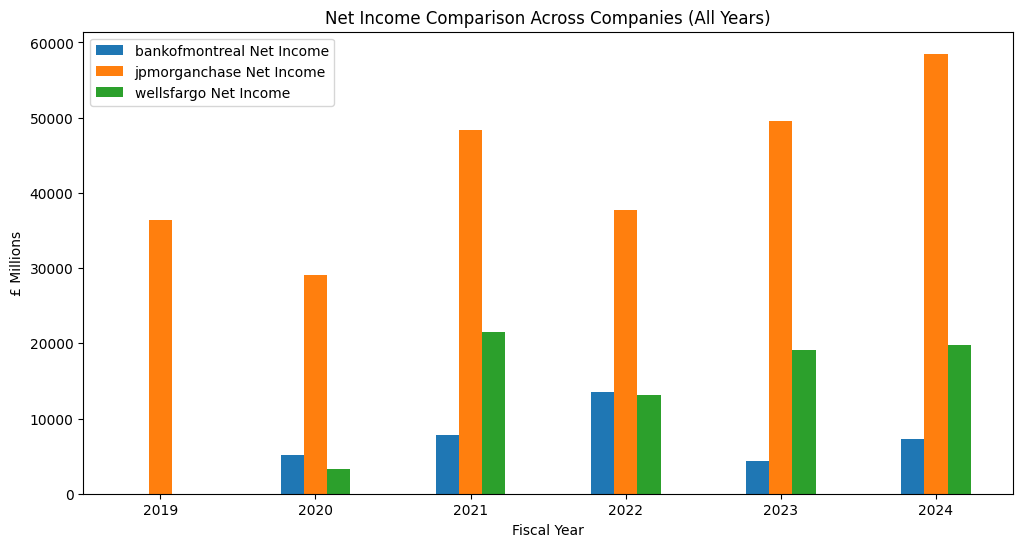

In [78]:

import numpy as np

# Filter only annual reports
df_filtered = df[df["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    ["revenue_millions", "net_income_millions"]
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    revenues = [company_data[company_data["fiscal_year"] == y]["revenue_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, revenues, width=bar_width, label=f"{company} Revenue")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue Comparison Across Companies (All Years)")
plt.legend()
plt.show()

# Repeat for Net Income
plt.figure(figsize=(12,6))
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies (All Years)")
plt.legend()
plt.show()


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [84]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


intellitrend-project-dev.db_reports_insights_annual_esg.all_reports_forecast


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


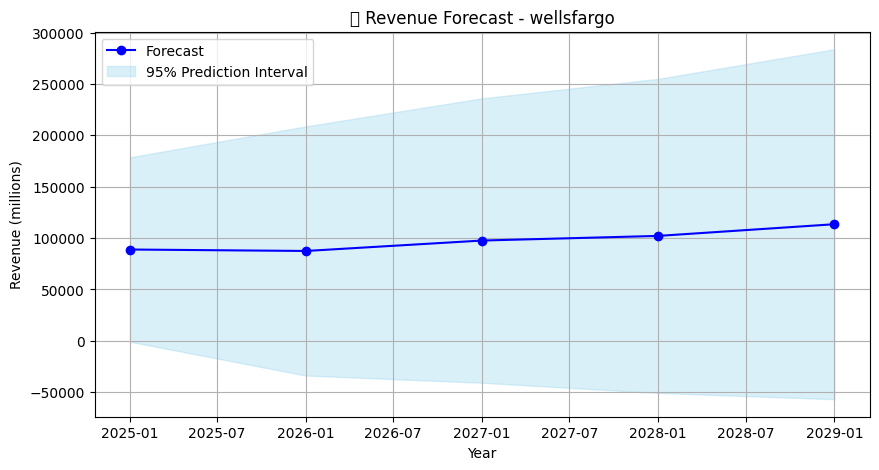

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


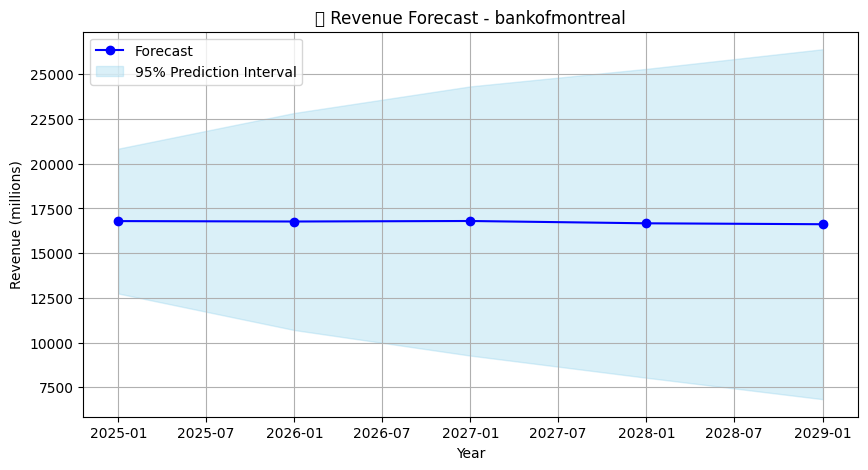

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


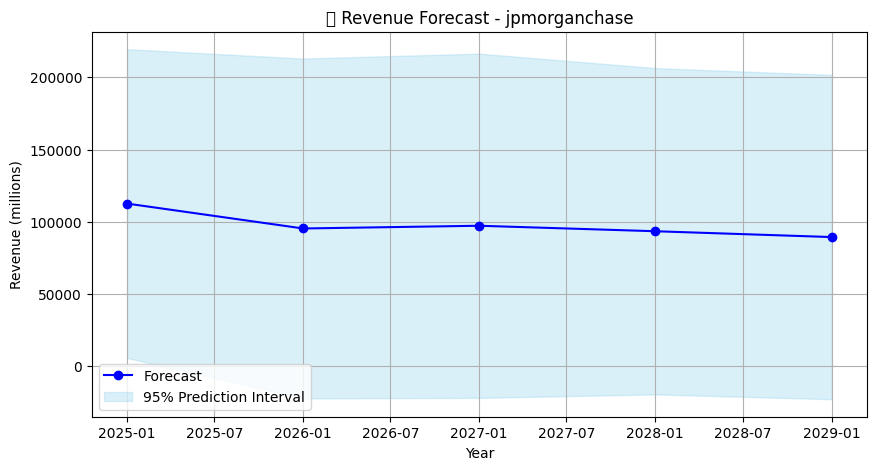

In [95]:

print(QUALIFIED_FORECAST_TABLE_ID)
# Load forecast table from BigQuery
df = bpd.read_gbq(f"Select * from {QUALIFIED_FORECAST_TABLE_ID}")

# Convert timestamp column
df['forecast_timestamp'] = bpd.to_datetime(df['forecast_timestamp'])
companies = df['company_name'].unique().to_pandas()  # get company names as list

for company in companies:
    company_df = df[df['company_name'] == company].to_pandas().sort_values("forecast_timestamp")

    plt.figure(figsize=(10, 5))
    plt.plot(company_df['forecast_timestamp'], company_df['forecast_value'], marker='o', label="Forecast", color="blue")
    plt.fill_between(
        company_df['forecast_timestamp'],
        company_df['prediction_interval_lower_bound'],
        company_df['prediction_interval_upper_bound'],
        color="skyblue", alpha=0.3, label="95% Prediction Interval"
    )

    plt.title(f"🔮 Revenue Forecast - {company}")
    plt.xlabel("Year")
    plt.ylabel("Revenue (millions)")
    plt.legend()
    plt.grid(True)
    plt.show()



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


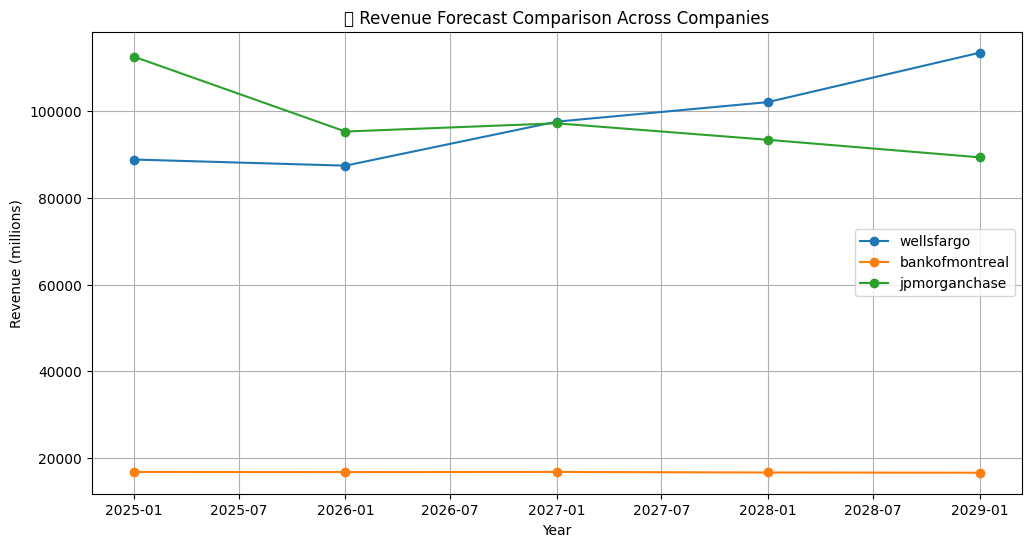

In [98]:
df_pandas = df.to_pandas()
df_pandas = df_pandas.sort_values("forecast_timestamp")
plt.figure(figsize=(12, 6))
for company in companies:
    company_df = df_pandas[df_pandas['company_name'] == company]
    plt.plot(company_df['forecast_timestamp'], company_df['forecast_value'], marker='o', label=company)

plt.title("🔮 Revenue Forecast Comparison Across Companies")
plt.xlabel("Year")
plt.ylabel("Revenue (millions)")
plt.legend()
plt.grid(True)
plt.show()


In [80]:
# import requests
# from google.cloud import bigquery

# PROJECT_ID = "intellitrend-project-dev"   # update if needed
# DATASET_ID = "db_reports_insights_annual_esg"
# TABLE_ID = "all_reports_annual_esg"

# # Step 0: Fetch file list from GitHub
# url = "https://api.github.com/repos/intellitrend-global/google_hackathon_bq_ai/contents/annual_esg_reports"
# response = requests.get(url)
# files = response.json()

# pdf_files = [(f["name"], f["download_url"]) for f in files if f["name"].endswith(".pdf")]

# print("📄 Found PDF files on GitHub:")
# for name, link in pdf_files:
#     print(f"   {name} -> {link}")

# # Step 1: Initialize BigQuery client
# client = bigquery.Client(project=PROJECT_ID)

# # Step 2: Ensure dataset exists (create if not)
# dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_ID)
# try:
#     client.get_dataset(dataset_ref)  # Check if it exists
#     print(f"✅ Dataset {DATASET_ID} already exists")
# except Exception:
#     dataset = bigquery.Dataset(dataset_ref)
#     dataset.location = "US"
#     client.create_dataset(dataset, timeout=30)
#     print(f"📦 Created dataset {DATASET_ID}")

# # Step 3: Define schema
# schema = [
#     bigquery.SchemaField("filename", "STRING"),
#     bigquery.SchemaField("uri", "STRING"),
# ]

# # Step 4: Prepare rows
# rows = [{"filename": name, "uri": link} for name, link in pdf_files]

# # Step 5: Load into BigQuery
# job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_TRUNCATE")
# table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

# job = client.load_table_from_json(rows, table_ref, job_config=job_config)
# job.result()

# print(f"✅ Table {table_ref} created/updated with {len(pdf_files)} GitHub files")
